In [1]:
import torch
import random
import os
import numpy as np
from torch import nn, einsum
from einops import rearrange, repeat
from math import pi
import PIL.Image as Image
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import glob
from perceiver import Perceiver
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorboard as tb

In [2]:
experiment_id = "N2yxC5ClSz6u6NjH09Z6bQ"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

In [3]:
train_acc = df[:20]
val_acc = df[20:40]
train_loss = df[40:60]
val_loss = df[60:80]

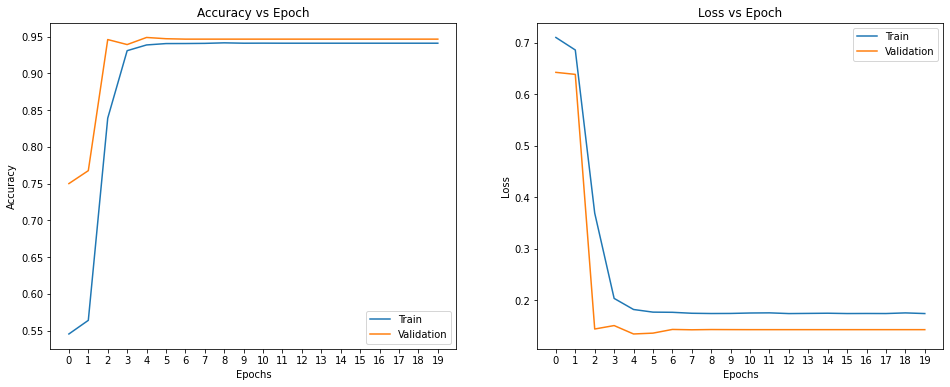

In [4]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("Accuracy vs Epoch")
plt.plot(train_acc["step"], train_acc["value"], label="Train")
plt.plot(val_acc["step"], val_acc["value"], label="Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 20, 1.0))

plt.subplot(1, 2, 2)
plt.title("Loss vs Epoch")
plt.plot(train_loss["step"], train_loss["value"], label="Train")
plt.plot(val_loss["step"], val_loss["value"], label="Validation")
plt.xticks(np.arange(0, 20, 1.0))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Perceiver with GeGlu.png", transparent=False)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

### Grab Data

In [6]:
right_knee_data_paths = np.array(sorted(glob.glob("AKOA_Analysis/*RIGHT.nii.gz_*.png")))
left_knee_data_paths = np.array(sorted(glob.glob("AKOA_Analysis/*LEFT.nii.gz_*.png")))

In [7]:
len(right_knee_data_paths), len(left_knee_data_paths)

(10560, 7640)

### Right Knee Data - 10560
* Train - 7920
* Val - 1320
* Test - 1320

In [8]:
train_rk, val_rk, test_rk = np.split(right_knee_data_paths, [7920, 7920 + 1320])

### Left Knee Data - 7640
* Train - 6040
* Val - 800
* Test - 800

In [9]:
train_lk, val_lk, test_lk = np.split(left_knee_data_paths, [6040, 6040 + 800])

All these splits have to be done manually using number of images instead of percentage due to slice data issue. The images are extracted from 3d MRI Scans and split into 40 chunks of 2d images. Hence, to prevent data leakage, data split process needs to be done manually.

In [10]:
# Rescale the image to prevent huge cross attention computation time 
# Make sure image retains scale
height = 228 // 3
width = 260 // 3

In [11]:
class Dataset():
    
    def __init__(self, right_knee, left_knee, transforms):
        self.data = np.concatenate((right_knee, left_knee))
        self.label = np.concatenate((np.zeros(len(right_knee)), np.ones(len(left_knee))))
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert('L')
        img = self.transforms(img)
        return img, self.label[idx]

In [12]:
train_transform = transforms.Compose(
    [
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]
)

In [13]:
test_dataset = Dataset(test_rk, test_lk, test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
device = torch.device('cuda')
model = torch.load("perceiver_best_model.pth", map_location=device)

In [15]:
def get_test_result(model, test_loader):
    total_test_correct = 0
    prediction = []
    model.eval()
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # forward
            output = model(inputs)
            # update logging
            total_test_correct += (output.argmax(dim=1) == labels).sum().item()
            prediction = np.concatenate((prediction, output.argmax(dim=1).detach().cpu().numpy()))
                
    return total_test_correct/len(test_loader.dataset), prediction

In [16]:
acc, prediction = get_test_result(model, test_loader)

In [17]:
true = test_dataset.label

In [18]:
cf_matrix = confusion_matrix(true, prediction)
df_cm = pd.DataFrame(cf_matrix, columns=["Right", "Left"], index=["Right", "Left"])

In [19]:
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

<AxesSubplot:title={'center':'Test Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

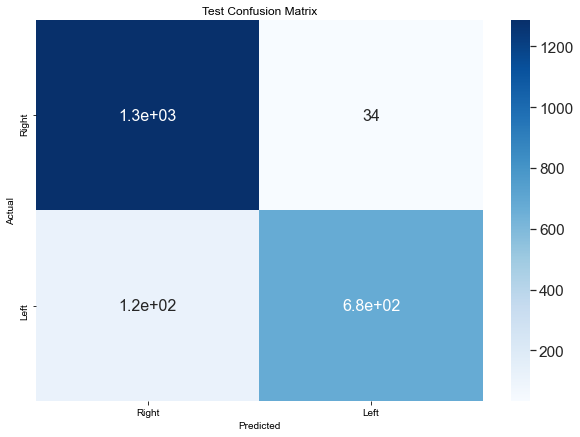

In [20]:
plt.figure(figsize = (10,7))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})